# CMC Ni/Co Prediction: ML Model

Train **individual models** for **nickel_ppm** and **cobalt_ppm** from the feature table (data prep notebook). Time-based train/test split; metrics and plots per target.

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
try:
    from xgboost import XGBRegressor
except ImportError:
    XGBRegressor = None

# Path to ML feature table (from data prep notebook)
PATH_ML_TABLE = 'data/ml_feature_table.parquet'
if not os.path.exists(PATH_ML_TABLE):
    PATH_ML_TABLE = os.path.join(os.path.dirname(os.getcwd()), 'data', 'ml_feature_table.parquet')

RANDOM_STATE = 42
TEST_FRAC = 0.2  # last 20% by time for test

# Data quality filters (from MODEL_IMPROVEMENT_IDEAS.md)
RATIO_MIN, RATIO_MAX = 1, 100   # feed_total_quantity / net_weight: keep 1 <= ratio <= 100
FEED_MATCH_MIN = 0.9             # keep rows with feed_mass_matched_pct >= this (NaN treated as 0)
USE_LOG_TARGETS = True           # train on log(ppm); often improves R2/MAE for ppm-scale targets
DO_HP_TUNING = True              # if True, run time-series CV tuning for GBR params
WINSORIZE_TARGETS = False        # if True, clip Ni/Co to 1st–99th percentile to reduce lab outliers

# Step 1: use only direct lab matches (0 = direct sample; from data prep hours_to_matched_sample)
HOURS_MATCHED_MAX = 0            # 0 = direct samples only; 1 = allow 1hr imputed; None = use all rows
# Step 3: simplified feature set (top 4–5 by correlation)
USE_MINIMAL_FEATURES = True
MINIMAL_FEATURE_COLS = ['feed_ni_pct_wt_avg', 'feed_ni_co_ratio', 'log_feed_total_quantity', 'hours_since_prev_lot', 'feed_co_pct_wt_avg']
# Step 4: two-stage Co model (same features + pred_ni from Ni model)
TWO_STAGE_CO = True
# Step 5: optional segment by time or shift
TRAIN_LAST_MONTHS = None        # e.g. 12 to train on last 12 months only; None = use all
SEGMENT_BY_SHIFT = False        # if True, train separate models for day vs night
# Step 6: run both LinearRegression and tree (XGB/GBR) and compare metrics
USE_XGBOOST = True   # tree = XGBoost if True and available, else GBR
RUN_BOTH_LINEAR_AND_TREE = True   # fit linear + tree and report test metrics for both
# Step 2 optional: also report R2 with last 15% as test (quick comparison)
RUN_ALT_SPLIT = True
TEST_FRAC_ALT = 0.15

## 1. Load ML feature table


In [ ]:
df = pd.read_parquet(PATH_ML_TABLE)
df['start_time'] = pd.to_datetime(df['start_time_local'])
df = df.sort_values('start_time').reset_index(drop=True)
print('Shape:', df.shape)
df.head()

Shape: (1372, 21)


,effective_sample_id,sample_id,start_time_local,end_time_local,lot_number,nickel_ppm,cobalt_ppm,net_weight,sample_type,feed_ni_pct_wt_avg,...,feed_ni_co_ratio,feed_total_quantity,feed_item_count,feed_mass_matched_pct,hours_since_prev_lot,hours_to_matched_sample,hour_of_day,day_of_week,shift,start_time
0,AA33486,AA33486,2024-04-06 08:55:47,2024-04-06 08:55:47,0030262404060001-3,288582.2,71656.8,771.0,inferred_single,0.103584,...,1.577513,19706.0,6,1.0,NaN,-1.914444,8,5,True,2024-04-06 08:55:47
1,AA33559,AA33559,2024-04-06 21:43:04,2024-04-06 21:43:05,0030262404060001-23,230774.2,61657.1,NaN,inferred_single,0.068624,...,4.521909,25419.3,5,1.0,12.788333,-1.004444,21,5,False,2024-04-06 21:43:04
2,AA33563,AA33563,2024-04-07 00:15:48,2024-04-07 00:34:41,0030262404070001-3,231206.1,62430.3,731.0,inferred_single,0.111344,...,12.676323,12129.0,3,1.0,2.860000,-0.575278,0,6,False,2024-04-07 00:15:48
3,AA33588,AA33588,2024-04-07 02:48:13,2024-04-07 03:23:50,0030262404070001-9,228489.7,55806.3,730.0,inferred_single,0.160641,...,4.678748,4729.0,2,1.0,2.819167,-0.593889,2,6,False,2024-04-07 02:48:13
4,AA33615,AA33615,2024-04-07 03:23:41,2024-04-07 04:07:03,0030262404070001-10,242990.6,56770.4,781.0,inferred_single,0.167410,...,5.197457,1764.0,2,1.0,0.720278,1.138333,3,6,False,2024-04-07 03:23:41


## 2. Ratio distribution and filter (1 ≤ ratio ≤ 100)

Distribution of feed_total_quantity / net_weight; restrict to 1 ≤ ratio ≤ 100 (and optional feed_mass_matched_pct ≥ threshold) for training.


Outliers (ratio < 1): 29
Outliers (ratio > 100): 62
Remaining: 1244 of 1335

Statistics (ratio in [1, 100]):
count    1244.000000
mean       28.543997
std        23.773735
min         1.015306
25%         8.698936
50%        21.105773
75%        44.616631
max        99.808201


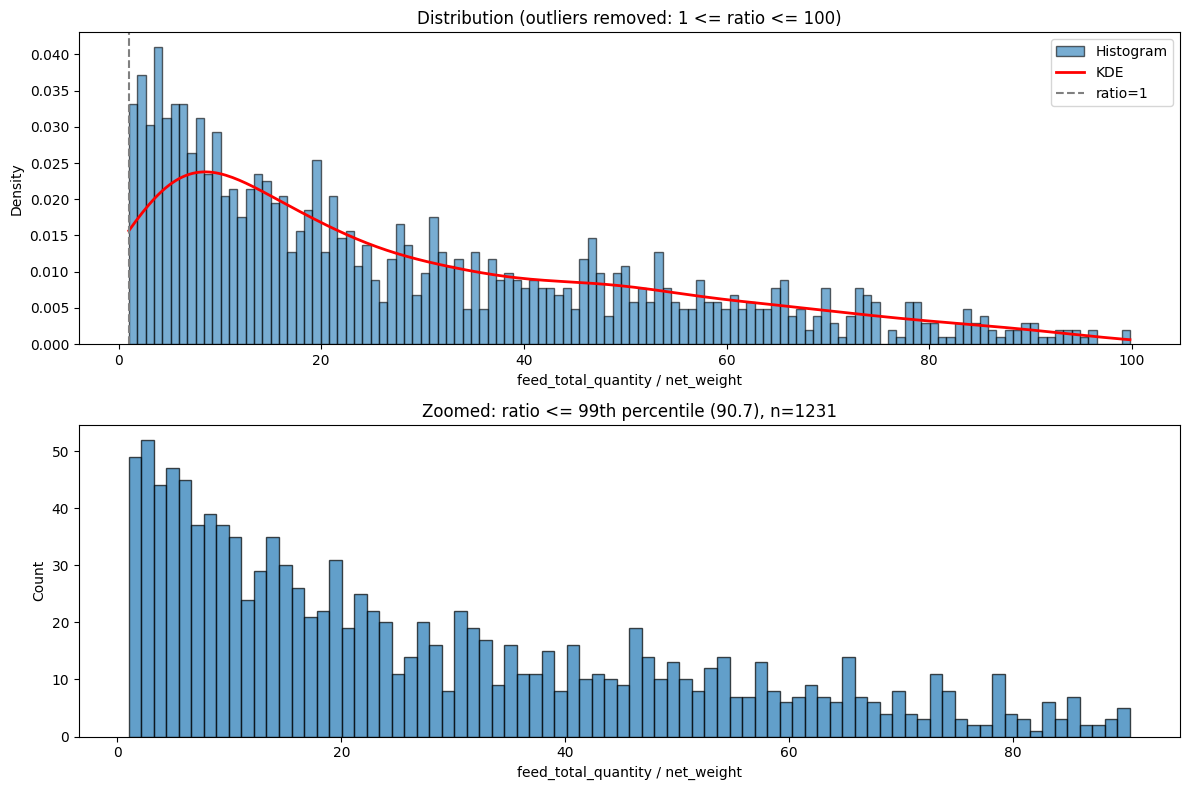

In [ ]:
# Ratio = feed_total_quantity / net_weight (avoid div by zero and inf)
ratio_raw = df['feed_total_quantity'] / df['net_weight'].replace(0, np.nan)
ratio_raw = ratio_raw.replace([np.inf, -np.inf], np.nan)
valid = ratio_raw.notna()
ratio = ratio_raw[valid]

# Outliers: ratio should be in [1, 100] (feed into lot >= output weight; cap extreme attribution)
outliers_low = (ratio < RATIO_MIN).sum()
outliers_high = (ratio > RATIO_MAX).sum()
ratio_clean = ratio[(ratio >= RATIO_MIN) & (ratio <= RATIO_MAX)]

print(f'Outliers (ratio < {RATIO_MIN}):', outliers_low)
print(f'Outliers (ratio > {RATIO_MAX}):', outliers_high)
print('Remaining:', len(ratio_clean), 'of', len(ratio))
print(f'\nStatistics (ratio in [{RATIO_MIN}, {RATIO_MAX}]):')
print(ratio_clean.describe().to_string())

# More granular: finer bins + KDE; second plot zoomed to main mass
from scipy import stats

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Full distribution (after removing ratio < 1): 120 bins + KDE
ax = axes[0]
ax.hist(ratio_clean, bins=120, edgecolor='black', alpha=0.6, density=True, label='Histogram')
kde = stats.gaussian_kde(ratio_clean)
x_kde = np.linspace(ratio_clean.min(), ratio_clean.max(), 300)
ax.plot(x_kde, kde(x_kde), 'r-', linewidth=2, label='KDE')
ax.axvline(1, color='gray', linestyle='--', label='ratio=1')
ax.set_xlabel('feed_total_quantity / net_weight')
ax.set_ylabel('Density')
ax.set_title(f'Distribution (outliers removed: {RATIO_MIN} <= ratio <= {RATIO_MAX})')
ax.legend()
ax.tick_params(axis='x', rotation=0)

# Zoomed: up to 99th percentile
ax2 = axes[1]
cap = ratio_clean.quantile(0.99)
ratio_cap = ratio_clean[ratio_clean <= cap]
ax2.hist(ratio_cap, bins=80, edgecolor='black', alpha=0.7)
ax2.set_xlabel('feed_total_quantity / net_weight')
ax2.set_ylabel('Count')
ax2.set_title(f'Zoomed: ratio <= 99th percentile ({cap:.1f}), n={len(ratio_cap)}')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# Use only rows with ratio in [RATIO_MIN, RATIO_MAX]
df = df.loc[ratio_clean.index].copy()
# Optional: keep only rows with most feed matched to master list
if 'feed_mass_matched_pct' in df.columns and FEED_MATCH_MIN > 0:
    matched = (df['feed_mass_matched_pct'].fillna(0) >= FEED_MATCH_MIN)
    n_before = len(df)
    df = df[matched].copy()
    print(f'Feed match filter (>= {FEED_MATCH_MIN}): kept {len(df)} of {n_before} rows')
# Step 1: keep only direct lab matches if column exists (hours_to_matched_sample <= HOURS_MATCHED_MAX)
if 'hours_to_matched_sample' in df.columns and HOURS_MATCHED_MAX is not None:
    direct = (df['hours_to_matched_sample'].fillna(np.inf) <= HOURS_MATCHED_MAX)
    n_before = len(df)
    df = df[direct].copy()
    print(f'Hours-to-matched filter (<= {HOURS_MATCHED_MAX}): kept {len(df)} of {n_before} rows')
# Step 5: optional — train on last N months only
if TRAIN_LAST_MONTHS is not None:
    cutoff = df['start_time'].max() - pd.DateOffset(months=TRAIN_LAST_MONTHS)
    df = df[df['start_time'] >= cutoff].copy()
    print(f'Last {TRAIN_LAST_MONTHS} months only: {len(df)} rows')
df = df.sort_values('start_time').reset_index(drop=True)
print(f'Dataset for training: {len(df)} rows (ratio {RATIO_MIN}–{RATIO_MAX}, feed_match >= {FEED_MATCH_MIN})')

Feed match filter (>= 0.9): kept 1127 of 1244 rows
Hours-to-matched filter (<= 0): kept 1043 of 1127 rows
Dataset for training: 1043 rows (ratio 1–100, feed_match >= 0.9)


## 3. Define features and targets


In [ ]:
TARGETS = ['nickel_ppm', 'cobalt_ppm']
FEATURE_COLS = [
    'feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'feed_ni_co_ratio',
    'feed_total_quantity', 'feed_item_count', 'feed_mass_matched_pct',
    'hours_since_prev_lot', 'hour_of_day', 'day_of_week', 'shift', 'net_weight'
]
FEATURE_COLS = [c for c in FEATURE_COLS if c in df.columns]

df_clean = df.dropna(subset=TARGETS).copy()
if WINSORIZE_TARGETS:
    for col in TARGETS:
        lo, hi = df_clean[col].quantile(0.01), df_clean[col].quantile(0.99)
        df_clean[col] = df_clean[col].clip(lo, hi)
    print('Targets winsorized at 1st–99th percentile.')
print(f'Rows with valid targets: {len(df_clean)}')
print('Features:', FEATURE_COLS)

Rows with valid targets: 1043
Features: ['feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'feed_ni_co_ratio', 'feed_total_quantity', 'feed_item_count', 'feed_mass_matched_pct', 'hours_since_prev_lot', 'hour_of_day', 'day_of_week', 'shift', 'net_weight']


## 4. Correlation: features vs targets

Pearson and Spearman correlation; use to guide feature engineering.


Pearson correlation (linear relationship):


,nickel_ppm,cobalt_ppm
feature,,
feed_ni_pct_wt_avg,0.604,-0.422
feed_co_pct_wt_avg,-0.353,0.408
feed_ni_co_ratio,0.511,-0.478
feed_total_quantity,0.359,-0.145
feed_item_count,-0.275,0.262
feed_mass_matched_pct,-0.124,0.067
hours_since_prev_lot,0.269,-0.135
hour_of_day,-0.001,-0.046
day_of_week,-0.031,-0.004


Spearman correlation (rank / monotonic relationship):


,nickel_ppm,cobalt_ppm
feature,,
feed_ni_pct_wt_avg,0.649,-0.510
feed_co_pct_wt_avg,-0.419,0.500
feed_ni_co_ratio,0.555,-0.562
feed_total_quantity,0.392,-0.143
feed_item_count,-0.289,0.286
feed_mass_matched_pct,-0.185,0.057
hours_since_prev_lot,0.377,-0.156
hour_of_day,-0.003,-0.020
day_of_week,-0.011,-0.026


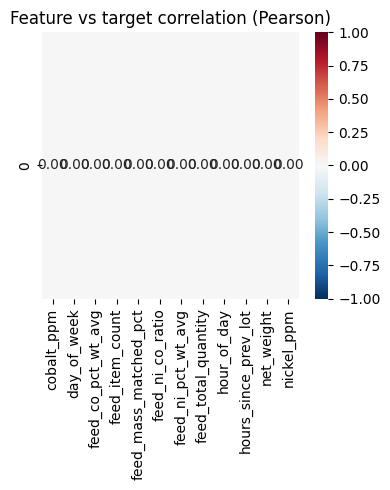

In [ ]:
# Use df_clean and numeric features only
num_cols = [c for c in FEATURE_COLS if c in df_clean.columns and np.issubdtype(df_clean[c].dtype, np.number)]
data = df_clean[num_cols + TARGETS].dropna(how='all', subset=num_cols)

corr_pearson = data[num_cols].corrwith(data['nickel_ppm']).to_frame('nickel_ppm')
corr_pearson['cobalt_ppm'] = data[num_cols].corrwith(data['cobalt_ppm'])
corr_pearson.index.name = 'feature'
print('Pearson correlation (linear relationship):')
display(corr_pearson.round(3))

corr_spearman = data[num_cols].corrwith(data['nickel_ppm'], method='spearman').to_frame('nickel_ppm')
corr_spearman['cobalt_ppm'] = data[num_cols].corrwith(data['cobalt_ppm'], method='spearman')
corr_spearman.index.name = 'feature'
print('Spearman correlation (rank / monotonic relationship):')
display(corr_spearman.round(3))

# Heatmap: features vs targets (use vmin/vmax to avoid All-NaN slice warning)
import seaborn as sns
corr_ft = data[num_cols].corrwith(data[TARGETS])
plot_df = (corr_ft if isinstance(corr_ft, pd.DataFrame) else corr_ft.to_frame().T).fillna(0)
fig, ax = plt.subplots(figsize=(4, max(5, len(plot_df) * 0.45)))
sns.heatmap(plot_df, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax, vmin=-1, vmax=1)
ax.set_title('Feature vs target correlation (Pearson)')
plt.tight_layout()
plt.show()

## 5. Feature engineering and reduced feature set

Add derived features, then keep only main drivers + key engineered features.


In [ ]:
# Derived features (add to df_clean so train/test get them)
# 1. Feed composition scaled to output mass (mass-balance style: feed_% * feed_qty ~ output)
df_clean['feed_ni_mass_scale'] = df_clean['feed_ni_pct_wt_avg'] * np.log1p(df_clean['feed_total_quantity'])
df_clean['feed_co_mass_scale'] = df_clean['feed_co_pct_wt_avg'] * np.log1p(df_clean['feed_total_quantity'])
# 2. Ratio feed_qty / net_weight (already >= 1 by filter; as feature it can help)
df_clean['ratio_feed_to_weight'] = df_clean['feed_total_quantity'] / df_clean['net_weight'].replace(0, np.nan)
# 3. Log-scale quantity (reduces skew)
df_clean['log_feed_total_quantity'] = np.log1p(df_clean['feed_total_quantity'])
# 4. Interaction: feed Ni and Co (chemistry mix)
df_clean['feed_ni_x_co'] = df_clean['feed_ni_pct_wt_avg'] * df_clean['feed_co_pct_wt_avg']
# 5. Composition × ratio (composition effect scaled by feed/lot ratio)
df_clean['feed_ni_ratio_interact'] = df_clean['feed_ni_pct_wt_avg'] * df_clean['ratio_feed_to_weight']
df_clean['feed_co_ratio_interact'] = df_clean['feed_co_pct_wt_avg'] * df_clean['ratio_feed_to_weight']

# Append new feature names (only those we created and exist)
NEW_FEATURES = ['feed_ni_mass_scale', 'feed_co_mass_scale', 'ratio_feed_to_weight', 'log_feed_total_quantity', 'feed_ni_x_co', 'feed_ni_ratio_interact', 'feed_co_ratio_interact']
NEW_FEATURES = [c for c in NEW_FEATURES if c in df_clean.columns]
FEATURE_COLS = FEATURE_COLS + NEW_FEATURES
print('Added engineered features:', NEW_FEATURES)
print('Total features:', len(FEATURE_COLS))

Added engineered features: ['feed_ni_mass_scale', 'feed_co_mass_scale', 'ratio_feed_to_weight', 'log_feed_total_quantity', 'feed_ni_x_co', 'feed_ni_ratio_interact', 'feed_co_ratio_interact']
Total features: 18


In [ ]:
# Reduced feature set: top correlations + key engineered + hours_since_prev_lot, log qty, interactions
# Step 3: optionally use minimal set (top 4–5) for comparison
if USE_MINIMAL_FEATURES:
    FEATURE_COLS = [c for c in MINIMAL_FEATURE_COLS if c in df_clean.columns]
    print('Minimal features for training (Step 3):', FEATURE_COLS)
else:
    FEATURE_COLS = [
        'feed_ni_pct_wt_avg', 'feed_co_pct_wt_avg', 'feed_ni_co_ratio',
        'feed_ni_mass_scale', 'feed_co_mass_scale', 'ratio_feed_to_weight',
        'hours_since_prev_lot', 'log_feed_total_quantity',
        'feed_ni_ratio_interact', 'feed_co_ratio_interact'
    ]
    FEATURE_COLS = [c for c in FEATURE_COLS if c in df_clean.columns]
    print('Reduced features for training:', FEATURE_COLS)

Minimal features for training (Step 3): ['feed_ni_pct_wt_avg', 'feed_ni_co_ratio', 'log_feed_total_quantity', 'hours_since_prev_lot', 'feed_co_pct_wt_avg']


## 6. Time-based train/test split


In [ ]:
n_test = int(len(df_clean) * TEST_FRAC)
n_train = len(df_clean) - n_test
train_df = df_clean.iloc[:n_train]
test_df = df_clean.iloc[n_train:]

X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGETS]
X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGETS]

print(f'Train: {len(X_train)}, Test: {len(X_test)}')
print(f'Test period: {test_df["start_time"].min().date()} to {test_df["start_time"].max().date()}')

Train: 835, Test: 208
Test period: 2025-12-26 to 2026-02-05


## 6a. Train vs test period comparison (Step 2: temporal check)

Compare mean/std of targets and key features between train and test to see if the failure is mainly temporal (distribution shift).

Train vs test (mean / std):


,train_mean,train_std,test_mean,test_std
nickel_ppm,276814.3425,64145.2753,210867.4779,60460.5004
cobalt_ppm,43658.4255,22739.8489,55703.3404,21802.1374
feed_ni_pct_wt_avg,0.1471,0.0418,0.1200,0.0350
feed_ni_co_ratio,8.6237,5.8611,5.9697,4.4178
feed_total_quantity,24655.3805,19253.1954,10707.8526,11894.3044


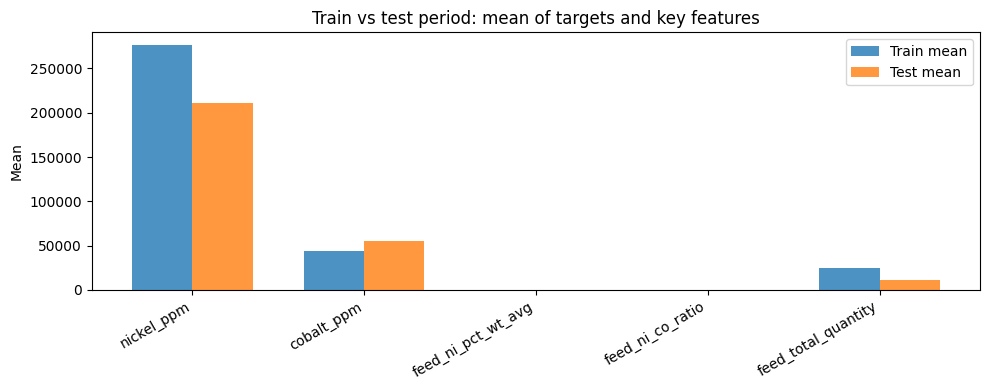

In [ ]:
# Compare train vs test: targets and key features (mean, std)
compare_cols = ['nickel_ppm', 'cobalt_ppm', 'feed_ni_pct_wt_avg', 'feed_ni_co_ratio', 'feed_total_quantity']
compare_cols = [c for c in compare_cols if c in train_df.columns and c in test_df.columns]
if compare_cols:
    summary = pd.DataFrame({
        'train_mean': train_df[compare_cols].mean(),
        'train_std': train_df[compare_cols].std(),
        'test_mean': test_df[compare_cols].mean(),
        'test_std': test_df[compare_cols].std(),
    })
    print('Train vs test (mean / std):')
    display(summary.round(4))
    # Bar plot: mean comparison
    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(len(compare_cols))
    w = 0.35
    ax.bar(x - w/2, summary['train_mean'], w, label='Train mean', color='C0', alpha=0.8)
    ax.bar(x + w/2, summary['test_mean'], w, label='Test mean', color='C1', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(compare_cols, rotation=30, ha='right')
    ax.set_ylabel('Mean')
    ax.set_title('Train vs test period: mean of targets and key features')
    ax.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No comparison columns available.')

In [ ]:
# Optional: R2 with last 15% as test (temporal sensitivity)
if RUN_ALT_SPLIT and 'df_clean' in dir():
    n_alt = len(df_clean)
    n_test_alt = int(n_alt * TEST_FRAC_ALT)
    n_train_alt = n_alt - n_test_alt
    train_alt = df_clean.iloc[:n_train_alt]
    test_alt = df_clean.iloc[n_train_alt:]
    X_tr = train_alt[FEATURE_COLS]
    X_te = test_alt[FEATURE_COLS]
    imp_alt = SimpleImputer(strategy='median').fit(X_tr)
    sc_alt = StandardScaler().fit(imp_alt.transform(X_tr))
    X_tr_s = sc_alt.transform(imp_alt.transform(X_tr))
    X_te_s = sc_alt.transform(imp_alt.transform(X_te))
    y_tr_ni = np.log1p(train_alt['nickel_ppm']) if USE_LOG_TARGETS else train_alt['nickel_ppm'].values
    y_te_ni = np.log1p(test_alt['nickel_ppm']) if USE_LOG_TARGETS else test_alt['nickel_ppm'].values
    y_tr_co = np.log1p(train_alt['cobalt_ppm']) if USE_LOG_TARGETS else train_alt['cobalt_ppm'].values
    y_te_co = np.log1p(test_alt['cobalt_ppm']) if USE_LOG_TARGETS else test_alt['cobalt_ppm'].values
    gbr_ni = GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=100, max_depth=4)
    gbr_co = GradientBoostingRegressor(random_state=RANDOM_STATE, n_estimators=100, max_depth=4)
    gbr_ni.fit(X_tr_s, y_tr_ni)
    gbr_co.fit(X_tr_s, y_tr_co)
    pred_ni = gbr_ni.predict(X_te_s)
    pred_co = gbr_co.predict(X_te_s)
    r2_ni_alt = r2_score(y_te_ni, pred_ni)
    r2_co_alt = r2_score(y_te_co, pred_co)
    print(f'Alt split (last {TEST_FRAC_ALT*100:.0f}% test): Ni R2={r2_ni_alt:.4f}, Co R2={r2_co_alt:.4f}')

Alt split (last 15% test): Ni R2=-0.0103, Co R2=-0.1646


## 7. Impute missing values and scale


In [ ]:
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

print('Imputation and scaling done.')

Imputation and scaling done.


## 7a. Hyperparameter tuning (time-series CV)

Optional: run `RandomizedSearchCV` with `TimeSeriesSplit` to tune GBR (n_estimators, max_depth, learning_rate, min_samples_leaf, subsample). Best params from Ni are used for both Ni and Co. Set `DO_HP_TUNING = False` in the config cell to skip.

In [ ]:
# Default GBR params; tuning (if enabled) updates gb_params for the next cell
gb_params = dict(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE)

if DO_HP_TUNING:
    tscv = TimeSeriesSplit(n_splits=5)
    param_dist = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'min_samples_leaf': [1, 2, 5],
        'subsample': [0.8, 1.0],
    }
    search = RandomizedSearchCV(
        GradientBoostingRegressor(random_state=RANDOM_STATE),
        param_dist, n_iter=20, cv=tscv, scoring='neg_mean_absolute_error',
        random_state=RANDOM_STATE, n_jobs=-1
    )
    y_ni_tune = np.log1p(y_train['nickel_ppm']) if USE_LOG_TARGETS else y_train['nickel_ppm']
    search.fit(X_train_scaled, y_ni_tune)
    gb_params = {**gb_params, **search.best_params_}
    print('Best params (from Ni tuning):', search.best_params_)
else:
    print('Skipping tuning (DO_HP_TUNING=False). Using default gb_params.')

Best params (from Ni tuning): {'subsample': 0.8, 'n_estimators': 50, 'min_samples_leaf': 5, 'max_depth': 5, 'learning_rate': 0.05}


## 8. Train individual models (Ni and Co)

Separate GradientBoostingRegressor for nickel_ppm and cobalt_ppm. **Metrics:** MAE, RMSE, R2.


In [ ]:
# Targets (log or raw)
if USE_LOG_TARGETS:
    y_train_ni = np.log1p(y_train['nickel_ppm'])
    y_train_co = np.log1p(y_train['cobalt_ppm'])
else:
    y_train_ni = y_train['nickel_ppm'].values
    y_train_co = y_train['cobalt_ppm'].values

# Linear regression (fit when RUN_BOTH_LINEAR_AND_TREE for comparison)
if RUN_BOTH_LINEAR_AND_TREE:
    model_ni_linear = LinearRegression()
    model_co_linear = LinearRegression()
    model_ni_linear.fit(X_train_scaled, y_train_ni)
    if TWO_STAGE_CO:
        pred_ni_train_lin = model_ni_linear.predict(X_train_scaled).reshape(-1, 1)
        X_train_aug_lin = np.hstack([X_train_scaled, pred_ni_train_lin])
        model_co_linear.fit(X_train_aug_lin, y_train_co)
    else:
        model_co_linear.fit(X_train_scaled, y_train_co)

# Tree model (XGB or GBR) — also used as primary for downstream plots
if USE_XGBOOST and XGBRegressor is not None:
    _p = dict(n_estimators=gb_params.get('n_estimators', 100), max_depth=gb_params.get('max_depth', 5),
              learning_rate=gb_params.get('learning_rate', 0.1), random_state=RANDOM_STATE)
    model_ni = XGBRegressor(**_p)
    model_co = XGBRegressor(**_p)
else:
    model_ni = GradientBoostingRegressor(**gb_params)
    model_co = GradientBoostingRegressor(**gb_params)
model_ni.fit(X_train_scaled, y_train_ni)
if TWO_STAGE_CO:
    pred_ni_train = model_ni.predict(X_train_scaled).reshape(-1, 1)
    X_train_aug = np.hstack([X_train_scaled, pred_ni_train])
    model_co.fit(X_train_aug, y_train_co)
else:
    model_co.fit(X_train_scaled, y_train_co)

tree_name = 'XGBoost' if (USE_XGBOOST and XGBRegressor is not None) else 'GBR'
print('Models fitted:', ('LinearRegression + ' if RUN_BOTH_LINEAR_AND_TREE else '') + tree_name, '(Ni and Co).' + (' Two-stage Co.' if TWO_STAGE_CO else ''))

Models fitted: LinearRegression + XGBoost (Ni and Co). Two-stage Co.


## 9. Evaluate on test set


In [ ]:
def predict_and_backscale(model_ni, model_co, X_te, two_stage, log_targets):
    pred_ni = model_ni.predict(X_te)
    if two_stage:
        X_te_aug = np.hstack([X_te, pred_ni.reshape(-1, 1)])
        pred_co = model_co.predict(X_te_aug)
    else:
        pred_co = model_co.predict(X_te)
    if log_targets:
        pred_ni, pred_co = np.expm1(pred_ni), np.expm1(pred_co)
    return pred_ni, pred_co

# Tree predictions (primary for downstream plots)
pred_ni_tree, pred_co_tree = predict_and_backscale(model_ni, model_co, X_test_scaled, TWO_STAGE_CO, USE_LOG_TARGETS)
y_pred_df = pd.DataFrame({'nickel_ppm': pred_ni_tree, 'cobalt_ppm': pred_co_tree}, index=y_test.index)

def print_metrics(name, pred_df):
    print(name + ':')
    for col in TARGETS:
        mae = mean_absolute_error(y_test[col], pred_df[col])
        rmse = np.sqrt(mean_squared_error(y_test[col], pred_df[col]))
        r2 = r2_score(y_test[col], pred_df[col])
        print(f'  {col}: MAE={mae:.1f}, RMSE={rmse:.1f}, R2={r2:.3f}')

tree_name = 'XGBoost' if (USE_XGBOOST and XGBRegressor is not None) else 'GBR'
if RUN_BOTH_LINEAR_AND_TREE:
    pred_ni_lin, pred_co_lin = predict_and_backscale(model_ni_linear, model_co_linear, X_test_scaled, TWO_STAGE_CO, USE_LOG_TARGETS)
    y_pred_df_linear = pd.DataFrame({'nickel_ppm': pred_ni_lin, 'cobalt_ppm': pred_co_lin}, index=y_test.index)
    print('Test set metrics (both models):')
    print_metrics('LinearRegression', y_pred_df_linear)
    print_metrics(tree_name, y_pred_df)
else:
    print('Test set metrics:')
    print_metrics(tree_name, y_pred_df)

Test set metrics (both models):
LinearRegression:
  nickel_ppm: MAE=48888.2, RMSE=60670.6, R2=-0.012
  cobalt_ppm: MAE=18706.7, RMSE=25354.8, R2=-0.359
XGBoost:
  nickel_ppm: MAE=46392.6, RMSE=58521.0, R2=0.059
  cobalt_ppm: MAE=17574.2, RMSE=22731.6, R2=-0.092


In [ ]:
# Relative error and baseline comparison
def mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print('Relative and baseline metrics:')
for col in TARGETS:
    mae = mean_absolute_error(y_test[col], y_pred_df[col])
    mean_actual = y_test[col].mean()
    mae_pct = 100 * mae / mean_actual if mean_actual else np.nan
    mape_val = mape(y_test[col].values, y_pred_df[col].values)
    # Baseline: predict training mean for everyone
    baseline_pred = np.full_like(y_test[col], y_train[col].mean())
    r2_baseline = r2_score(y_test[col], baseline_pred)
    mae_baseline = mean_absolute_error(y_test[col], baseline_pred)
    r2_model = r2_score(y_test[col], y_pred_df[col])
    print(f'  {col}:')
    print(f'    MAE = {mae:.0f} ppm ({mae_pct:.1f}% of mean); MAPE = {mape_val:.1f}%')
    print(f'    Baseline (predict mean): MAE = {mae_baseline:.0f}, R2 = {r2_baseline:.3f}')
    print(f'    Model: R2 = {r2_model:.3f} (beat baseline if R2 > 0)')

Relative and baseline metrics:
  nickel_ppm:
    MAE = 46393 ppm (22.0% of mean); MAPE = 28.6%
    Baseline (predict mean): MAE = 75549, R2 = -1.195
    Model: R2 = 0.059 (beat baseline if R2 > 0)
  cobalt_ppm:
    MAE = 17574 ppm (31.5% of mean); MAPE = 34.9%
    Baseline (predict mean): MAE = 19163, R2 = -0.307
    Model: R2 = -0.092 (beat baseline if R2 > 0)


### Step 5b. Segment by shift (optional)

If `SEGMENT_BY_SHIFT = True`, train separate Ni/Co models for day vs night and report R2 per segment.

In [ ]:
# Step 5b: optional segment by shift (day vs night)
if SEGMENT_BY_SHIFT and 'shift' in train_df.columns and 'shift' in test_df.columns:
    seg_vals = train_df['shift'].dropna().unique()
    if len(seg_vals) < 2:
        print('Segment by shift: need at least 2 shift values in train; skipping.')
    else:
        y_ni = np.log1p(train_df['nickel_ppm']) if USE_LOG_TARGETS else train_df['nickel_ppm'].values
        y_co = np.log1p(train_df['cobalt_ppm']) if USE_LOG_TARGETS else train_df['cobalt_ppm'].values
        r2_ni_seg, r2_co_seg = {}, {}
        for seg in seg_vals:
            tr = train_df['shift'] == seg
            te = test_df['shift'] == seg
            if tr.sum() < 10 or te.sum() < 2:
                continue
            X_tr_s = scaler.transform(imputer.transform(train_df.loc[tr, FEATURE_COLS]))
            X_te_s = scaler.transform(imputer.transform(test_df.loc[te, FEATURE_COLS]))
            m_ni = GradientBoostingRegressor(**gb_params).fit(X_tr_s, y_ni[tr])
            m_co = GradientBoostingRegressor(**gb_params).fit(X_tr_s, y_co[tr])
            p_ni = m_ni.predict(X_te_s)
            p_co = m_co.predict(X_te_s)
            if USE_LOG_TARGETS:
                p_ni, p_co = np.expm1(p_ni), np.expm1(p_co)
            r2_ni_seg[seg] = r2_score(test_df.loc[te, 'nickel_ppm'], p_ni)
            r2_co_seg[seg] = r2_score(test_df.loc[te, 'cobalt_ppm'], p_co)
        print('R2 by shift (test):', {s: (r2_ni_seg.get(s), r2_co_seg.get(s)) for s in seg_vals})
else:
    if SEGMENT_BY_SHIFT:
        print('Segment by shift: shift column missing in train/test; skipping.')

### 9a. How to improve (given correlations and R2)

- **Try log-scale targets:** Set `USE_LOG_TARGETS = True` in the config cell and re-run. Ni/Co often have multiplicative spread; training on log(ppm) can improve R2 and MAE.
- **Top-correlated features:** Ni is best predicted by `feed_ni_pct_wt_avg` (0.60), `feed_ni_co_ratio` (0.51), `feed_total_quantity` (0.36). Co by `feed_co_pct_wt_avg` (0.41), `feed_ni_co_ratio` (-0.48), `feed_item_count` (0.27). The reduced feature set already includes these; if overfitting, try dropping weak ones (`feed_mass_matched_pct`, `hour_of_day`, `day_of_week`, `net_weight`).
- **Residual plots below:** If residuals are structured (e.g. underprediction when feed_ni is high), add interactions or try a different model family (e.g. XGBoost).
- **Two-stage Co:** Train Co model using features + predicted Ni (chemistry link); can help if Ni/Co are tightly related in your process.
- **Temporal shift:** If test period behaves differently, consider a longer training window or segment models by period.

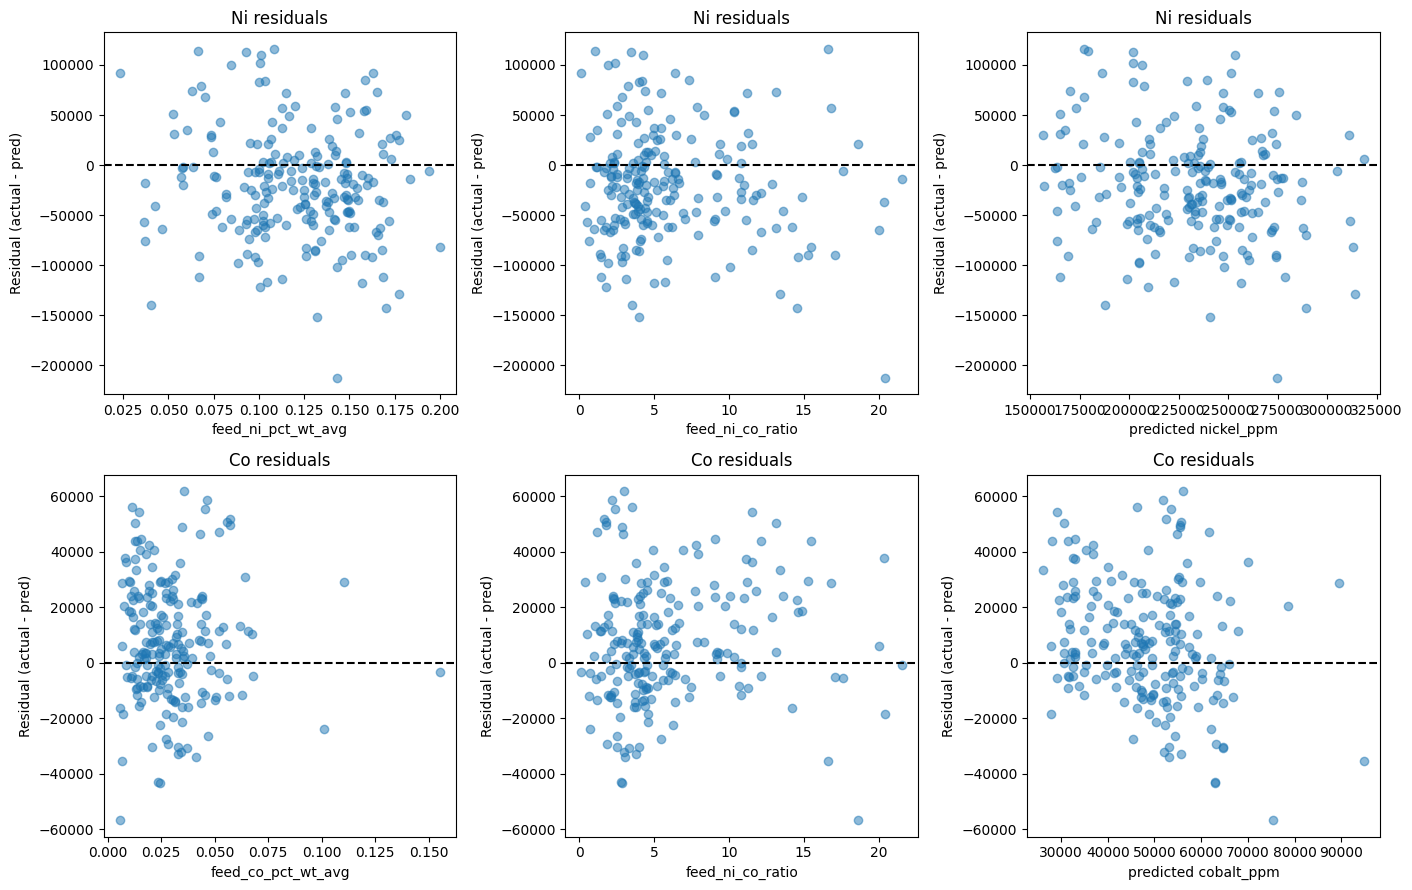

In [ ]:
# Residual diagnostics: residuals vs top-correlated features (test set)
res_ni = (y_test['nickel_ppm'] - y_pred_df['nickel_ppm']).values
res_co = (y_test['cobalt_ppm'] - y_pred_df['cobalt_ppm']).values

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
# Ni: residuals vs feed_ni_pct_wt_avg, feed_ni_co_ratio, predicted Ni
for ax, (xlabel, xval) in zip(axes[0], [
    ('feed_ni_pct_wt_avg', test_df['feed_ni_pct_wt_avg'].values if 'feed_ni_pct_wt_avg' in test_df.columns else np.arange(len(res_ni))),
    ('feed_ni_co_ratio', test_df['feed_ni_co_ratio'].values if 'feed_ni_co_ratio' in test_df.columns else np.arange(len(res_ni))),
    ('predicted nickel_ppm', y_pred_df['nickel_ppm'].values),
]):
    ax.scatter(xval, res_ni, alpha=0.5)
    ax.axhline(0, color='k', linestyle='--')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Residual (actual - pred)')
    ax.set_title('Ni residuals')
# Co: residuals vs feed_co_pct_wt_avg, feed_ni_co_ratio, predicted Co
for ax, (xlabel, xval) in zip(axes[1], [
    ('feed_co_pct_wt_avg', test_df['feed_co_pct_wt_avg'].values if 'feed_co_pct_wt_avg' in test_df.columns else np.arange(len(res_co))),
    ('feed_ni_co_ratio', test_df['feed_ni_co_ratio'].values if 'feed_ni_co_ratio' in test_df.columns else np.arange(len(res_co))),
    ('predicted cobalt_ppm', y_pred_df['cobalt_ppm'].values),
]):
    ax.scatter(xval, res_co, alpha=0.5)
    ax.axhline(0, color='k', linestyle='--')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Residual (actual - pred)')
    ax.set_title('Co residuals')
plt.tight_layout()
plt.show()

## 10. Predicted vs actual (test set)


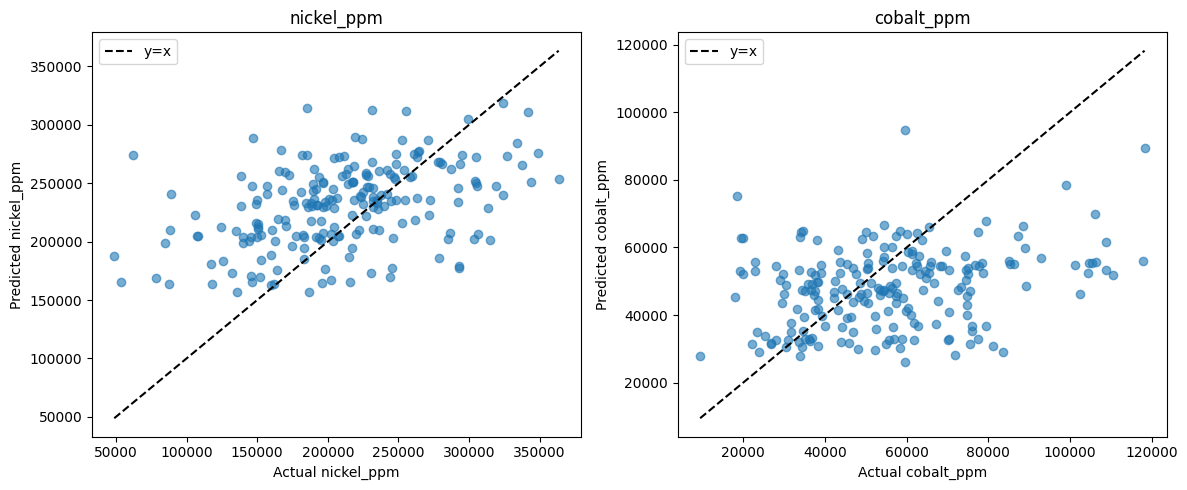

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, col in enumerate(TARGETS):
    axes[i].scatter(y_test[col], y_pred_df[col], alpha=0.6)
    axes[i].plot([y_test[col].min(), y_test[col].max()], [y_test[col].min(), y_test[col].max()], 'k--', label='y=x')
    axes[i].set_xlabel(f'Actual {col}')
    axes[i].set_ylabel(f'Predicted {col}')
    axes[i].set_title(col)
    axes[i].legend()
plt.tight_layout()
plt.show()